In [1]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import umap.umap_ as umap
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import seaborn as sns

from collections import Counter
from tqdm import tqdm
import warnings
import logging
import random
import pickle
import json
import os

from IPython.core.interactiveshell import InteractiveShell

# from samolet_parking_lot.modules.cv import *
from samolet_parking_lot.modules.feature_engineering import *
from samolet_parking_lot.modules.features_selection import *
from samolet_parking_lot.modules.hyperparam_tuning import *
from samolet_parking_lot.modules.model import *
from samolet_parking_lot.modules.utils import *

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last
seed_everything()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Stage 1. Data Preparation

In [2]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [3]:
data = create_date_features(data)

In [4]:
# drop columns with big share of missing values
not_null_columns_names = get_not_null_columns_names(data, threshold=.999)
# X_train = X_train[null_columns_names]
data_for_split = data[not_null_columns_names]

In [5]:
# def target_rate_improvements(data, subjects, extra):
#     """Compute the improvement in squared difference between the positive rate in each fold vs the overall positive rate in the dataset"""
#     target_rate = data['target'].mean()
#     rate_without_extra = data.loc[lambda d: d['client_id'].isin(subjects), 'target'].mean()
#     rate_with_extra =  data.loc[lambda d: d['client_id'].isin(subjects + [extra]), 'target'].mean()
#     rate_without_extra = 0 if np.isnan(rate_without_extra) else rate_without_extra
# 
#     return (rate_without_extra - target_rate)**2 - (rate_with_extra - target_rate)**2
# 
# 
# def size_improvement(data, subjects, n_folds):
#     """compute the improvement in squared difference between the number of observations in each fold vs the expected number of observations"""
#     target_obs_per_fold = len(data) / n_folds
# 
#     return [(target_obs_per_fold - len(data.loc[lambda d: d['client_id'].isin(subject)])) ** 2 for subject in subjects.values()]
# 
# n_folds = 5
# test_subjects_per_fold = {fold: [] for fold in range(n_folds)}
# subjects_to_assign = list(range(100))
# 
# for subject in tqdm(data['client_id'].unique()):
#     target_rate_improvement = np.array([target_rate_improvements(data, test_subjects_per_fold[fold], subject) for fold in range(n_folds)])
#     size_improvements = np.array(size_improvement(data, test_subjects_per_fold, n_folds)) * 0.001
#     best_fold = np.argmax(target_rate_improvement +size_improvements)
#     test_subjects_per_fold[best_fold] += [subject]

In [6]:
# for fold, subjects in test_subjects_per_fold.items():
#     print('-'*80)
#     print(f'for fold {fold}')
#     test_data = data.loc[lambda d: d['client_id'].isin(subjects)]
#     train_data = data.loc[lambda d: ~d['client_id'].isin(subjects)]
# 
#     print('train - pos rate:', train_data['target'].mean(), 'size:', len(train_data))
#     print('test - pos rate:', test_data['target'].mean(), 'size:', len(test_data))

In [7]:
# split on train, valid, test with client_id being only withing one split
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_split(data_for_split)  # fix potential problem (connected to first getting non_null columns, and then removing target, client_id, date) if time will be

In [8]:
X = pd.concat([X_train, X_valid, X_test], ignore_index=True)
y = pd.concat([y_train, y_valid, y_test], ignore_index=True)

# Stage 2. Data Analysis

### Data Inspection

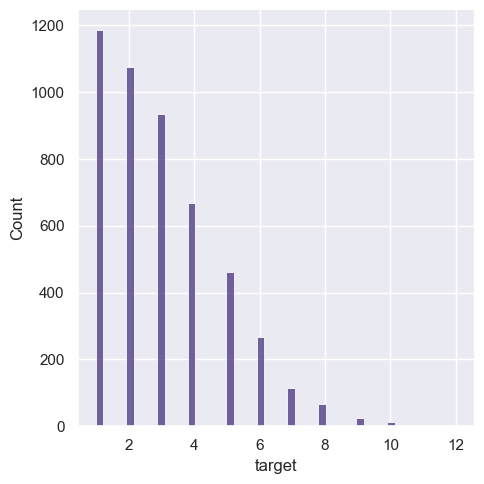

In [9]:
# Qnt of entries per client_id
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

In [10]:
plt_data = (
    data[['client_id', 'target']]
    .groupby('client_id', as_index=True)
    .agg(qnt=('target', 'count'),
         sum=('target', 'sum'))
)
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']

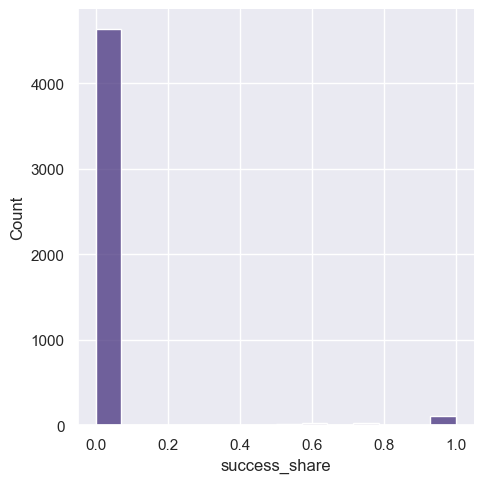

In [11]:
# distribution of share of successful events per client
ax = sns.displot(plt_data.success_share)
plt.show()

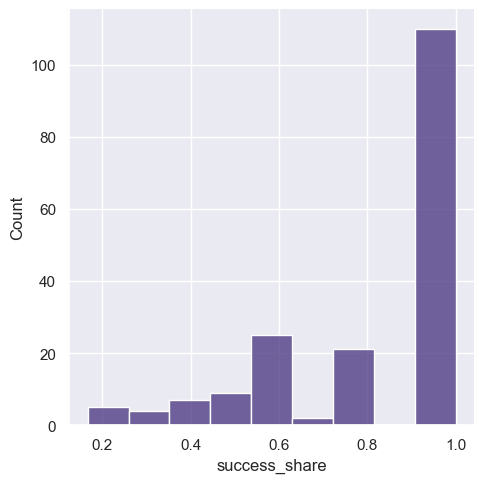

In [12]:
# distribution of share of successful events per client (w/o 0%) (among those who purchases parking lot)
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

In [13]:
# share of clents with 1
(
    data[['client_id', 'target']]
    .groupby('target', as_index=True)
    .agg(qnt=('client_id', 'count'))
)

,qnt
target,
0,14020
1,436


In [14]:
# check whether col1454 is a leak
client_id_duplicate_check = data.groupby('client_id')['col1454'].nunique()
print(
    'min:', client_id_duplicate_check.min(),
    ' max:', client_id_duplicate_check.max(),
    ' avg:', client_id_duplicate_check.mean(),
      )

min: 1  max: 1  avg: 1.0


In [15]:
client_id_duplicate_check = data.groupby('col1454')['client_id'].nunique()
print(
    'min:', client_id_duplicate_check.min(),
    ' max:', client_id_duplicate_check.max(),
    ' avg:', client_id_duplicate_check.mean(),
)

min: 1  max: 1  avg: 1.0


### Plot Possible Clusters

In [16]:
data_umap = data[data.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [17]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_umap)
embedding.shape

(14456, 2)

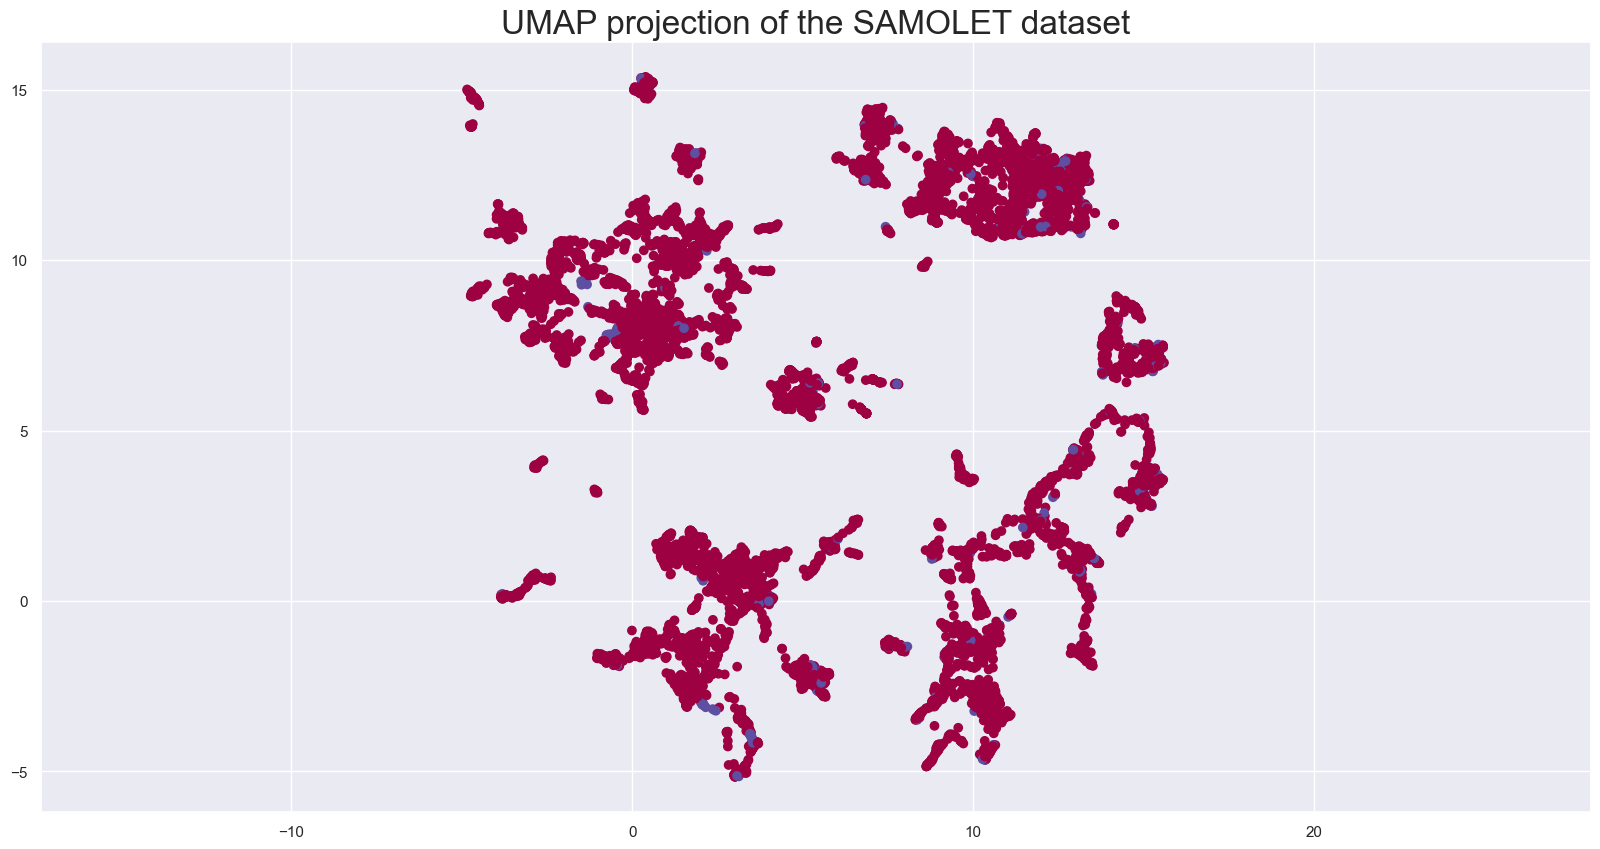

In [18]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data.target,
    cmap='Spectral',
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SAMOLET dataset', fontsize=24);

### Dimensionality Reduction

In [19]:
data_umap = X_train[X_train.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [20]:
reducer = umap.UMAP(n_components=50)
umap_embedding = reducer.fit_transform(data_umap)

In [21]:
pca = PCA(n_components=400, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)

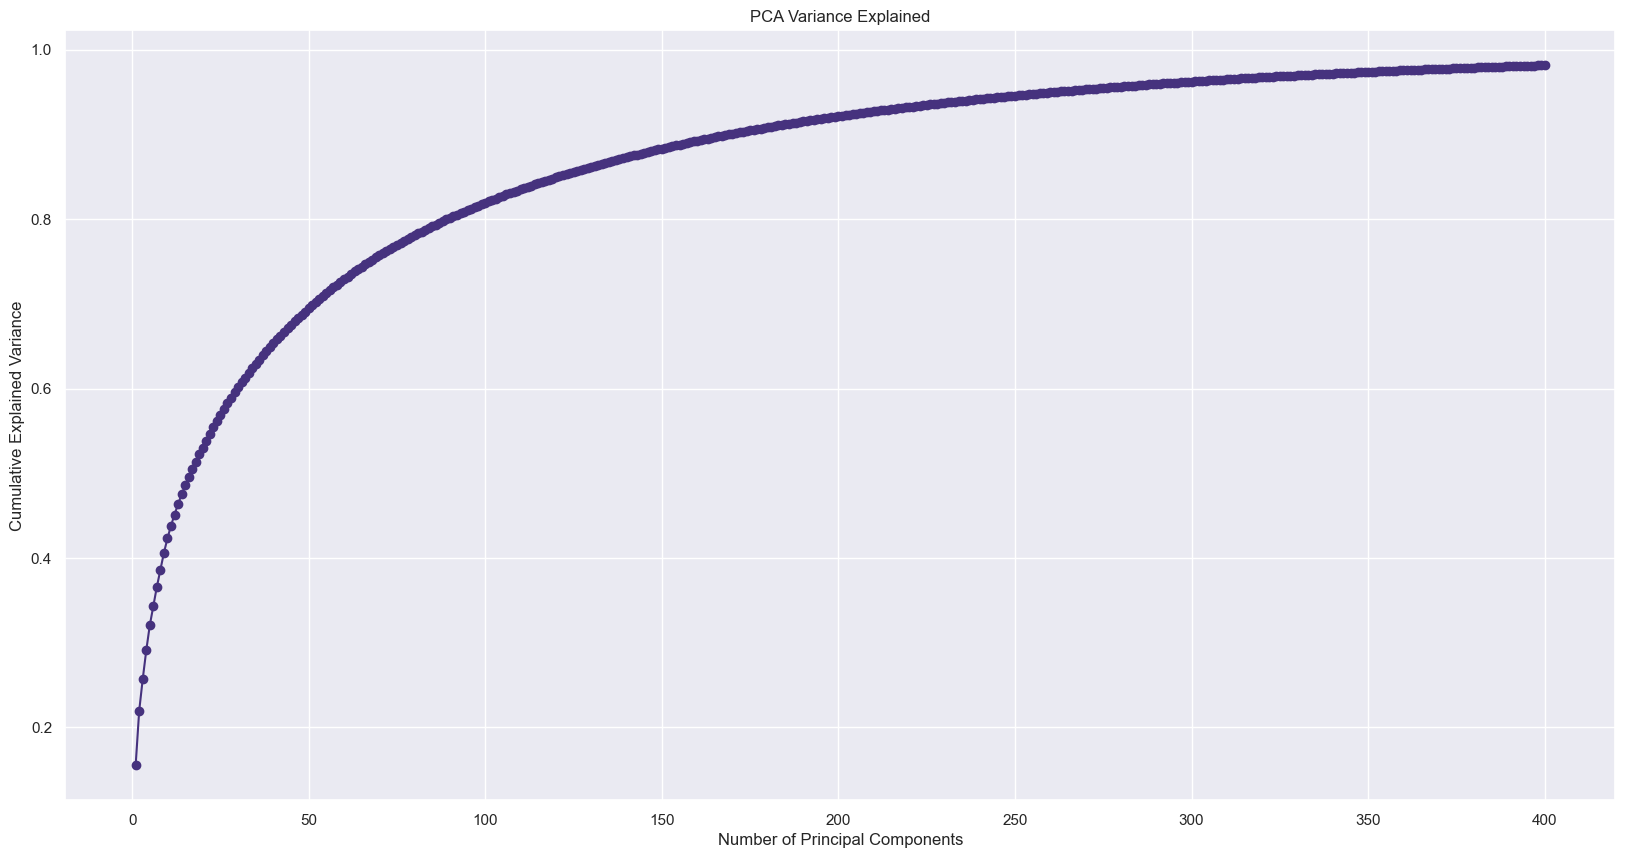

Plot was saved to PCA_varian_without_UMAP


<Figure size 2000x1000 with 0 Axes>

In [22]:
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

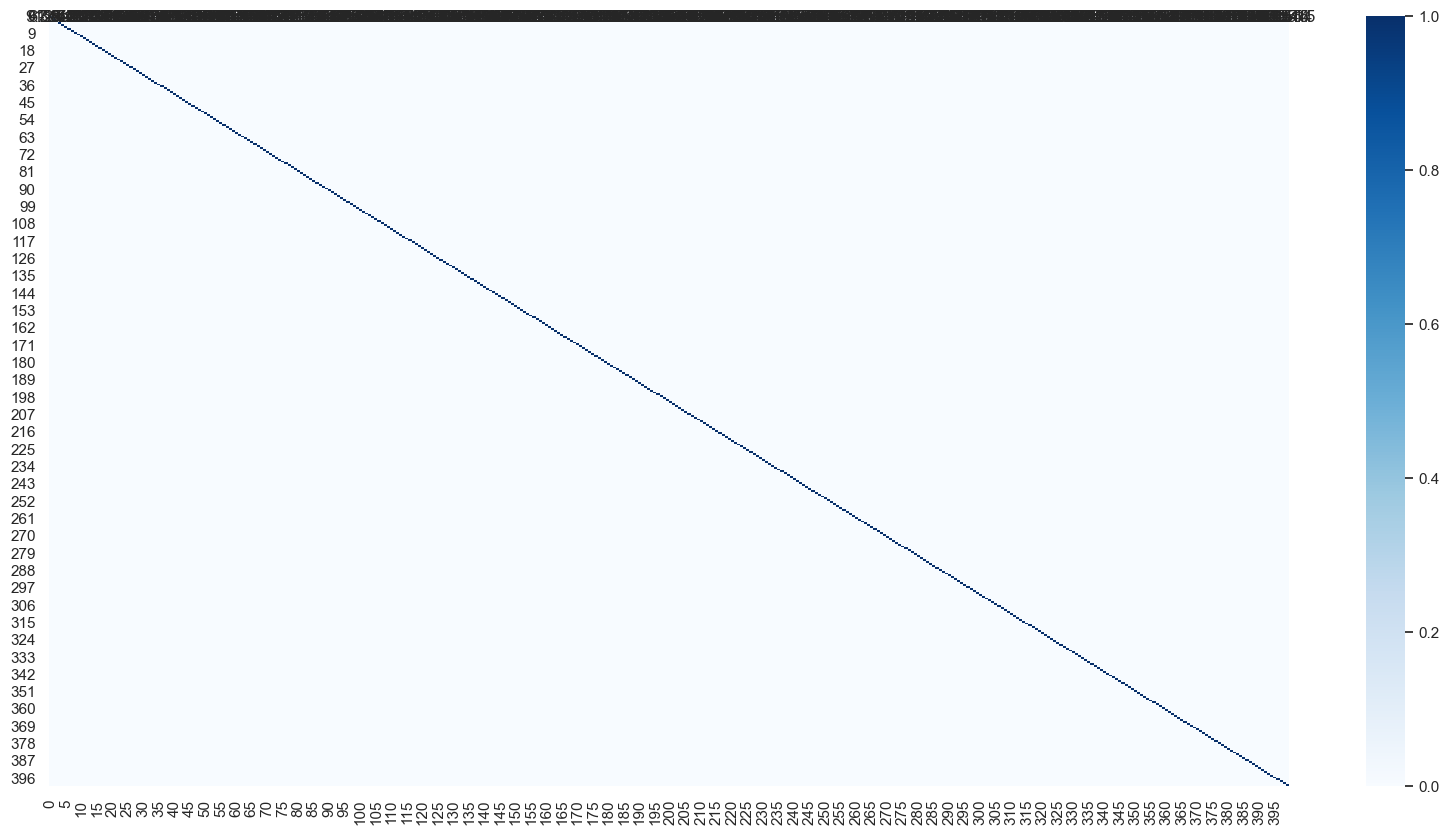

In [23]:
ax = sns.heatmap(pd.DataFrame(pca_embedding).corr(), annot=True, cmap='Blues')
plt.show()

# Stage 3. Model (w/o Feature Selection)

In [24]:
model = catboost_model_classifier(X_train, X_valid, y_train, y_valid)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7608259659462999

Classification report of the model
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      1527
           1       0.19      0.60      0.29        48

    accuracy                           0.91      1575
   macro avg       0.59      0.76      0.62      1575
weighted avg       0.96      0.91      0.93      1575

ROC-AUC score is:  0.7608259659462999


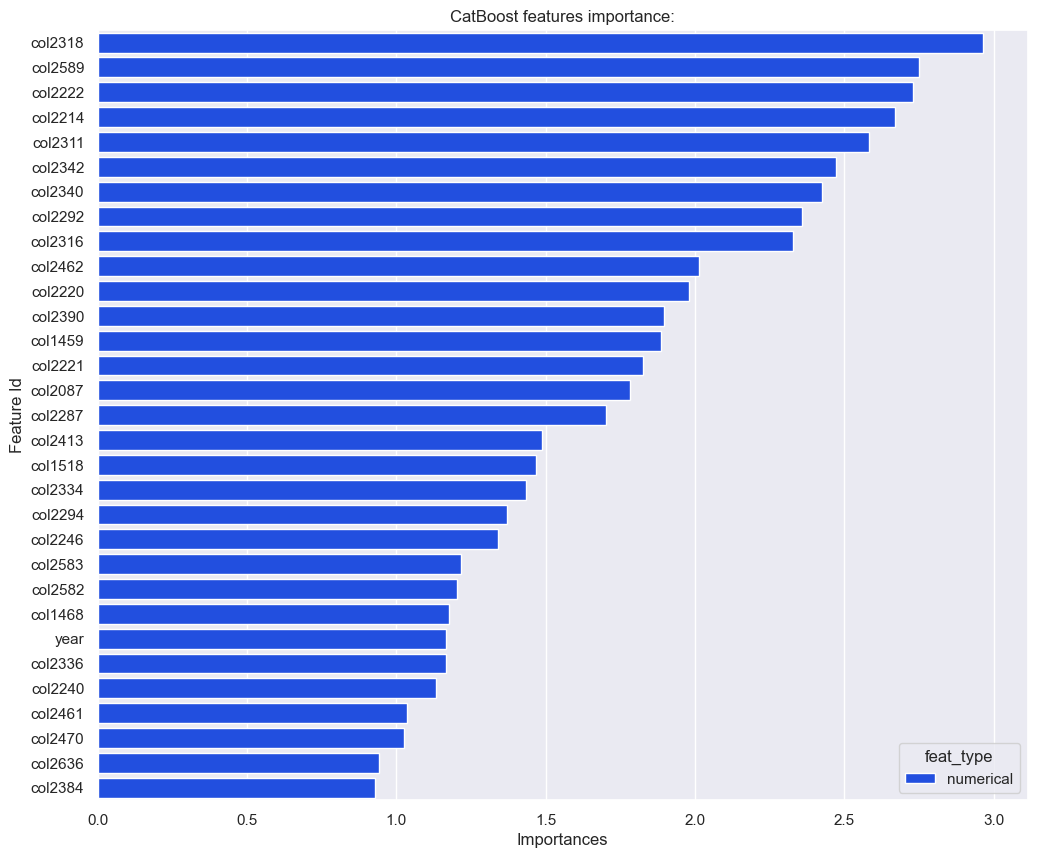

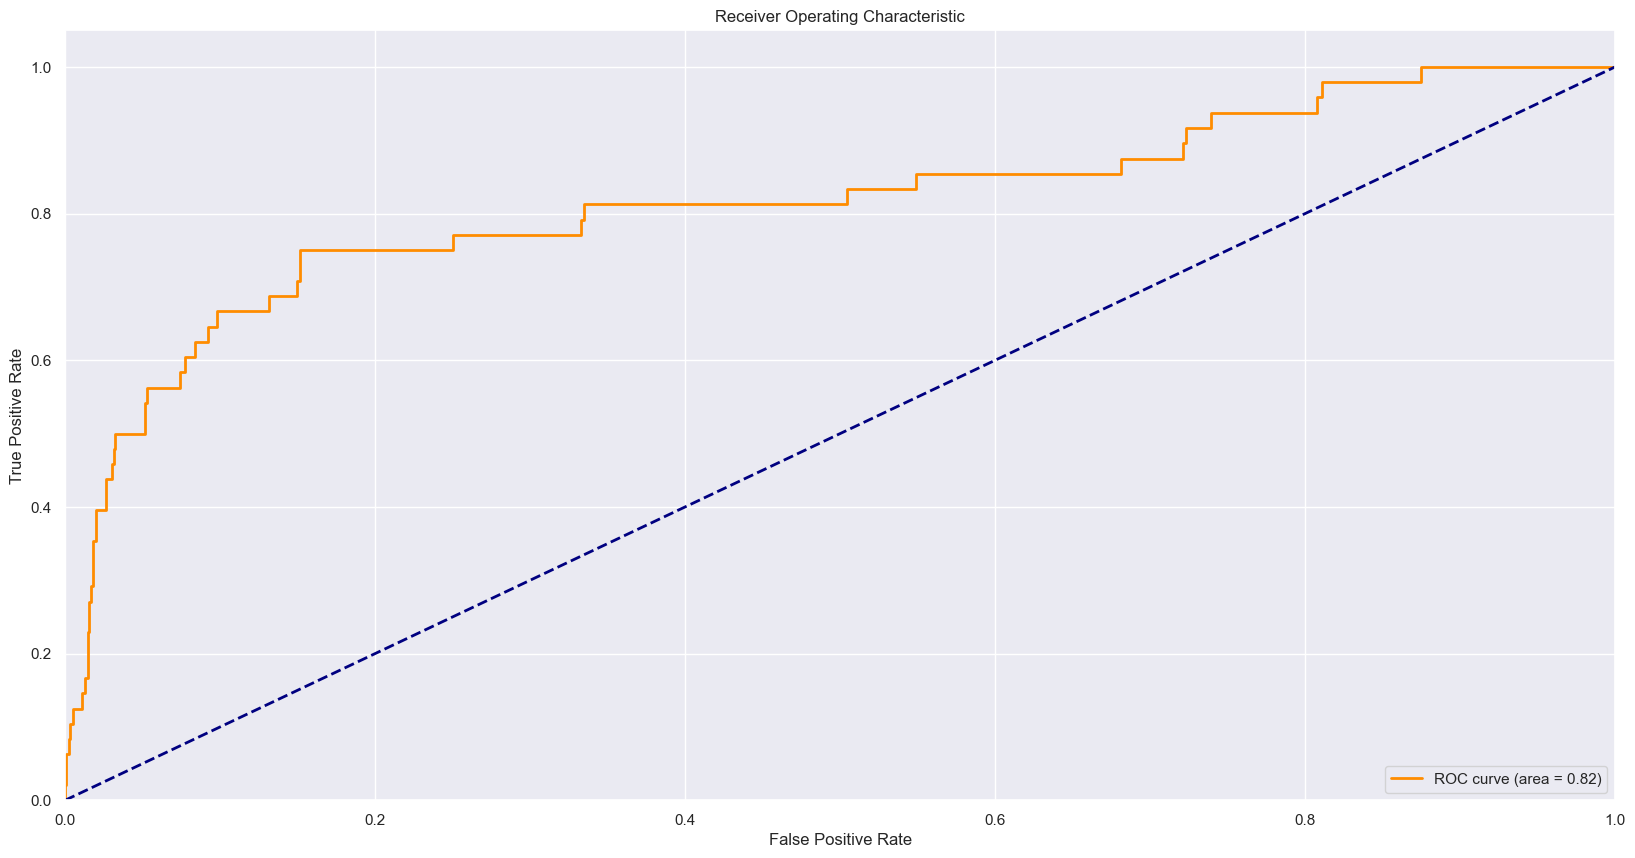

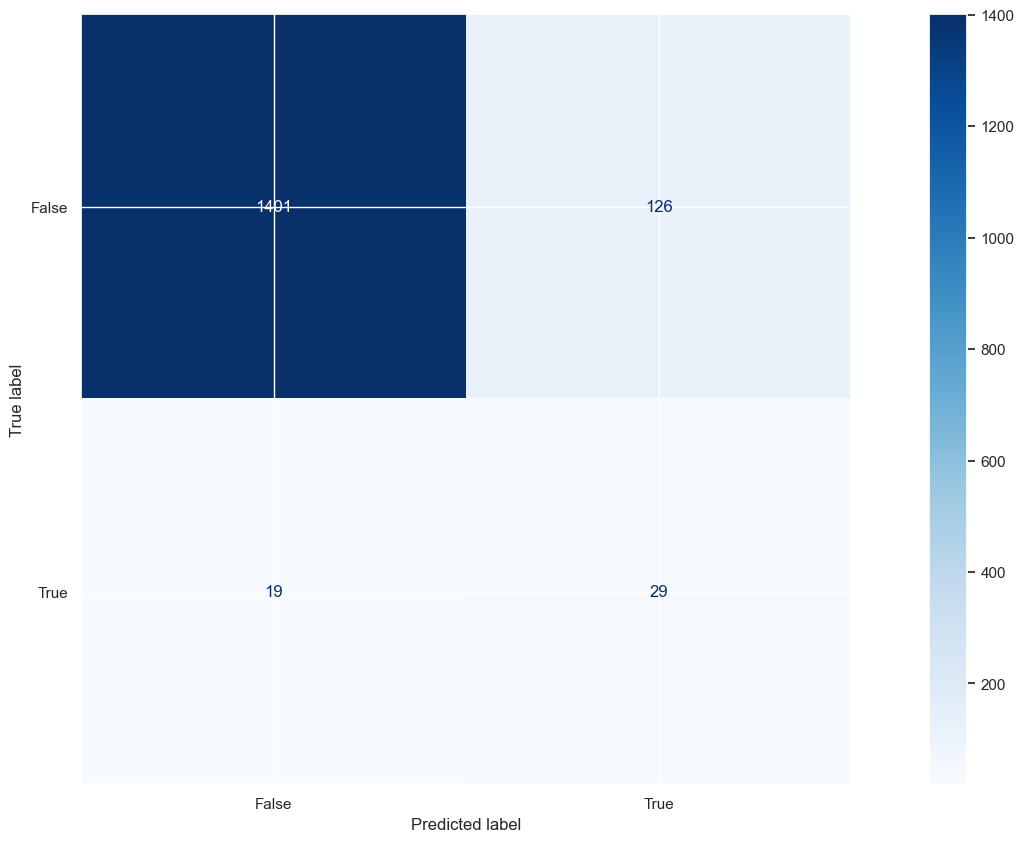

In [25]:
plot_model_info(model, X_test, y_test, catboost=True,)  #categorical_columns

# Step 4. Feature Selection

In [29]:
shrunk_columns_anew = True
if shrunk_columns_anew:
    useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=False)
    useful_column_indices_rf = get_random_feat_important_features(X_train, y_train, X_valid, y_valid)
    with open('useful_column_indices_sk_new.pkl', 'wb') as fp:
        pickle.dump(useful_column_indices_sk, fp)
    with open('useful_column_indices_rf_new.pkl', 'wb') as fp:
        pickle.dump(useful_column_indices_rf, fp)
else:
    with open('useful_column_indices_sk.pkl', 'rb') as fp:
        useful_column_indices_sk = pickle.load(fp)
    with open('useful_column_indices_rf.pkl', 'rb') as fp:
        useful_column_indices_rf = pickle.load(fp)
useful_column_indices_union = list(set(useful_column_indices_sk + useful_column_indices_rf))
useful_column_indices_intersect = lists_intersection(useful_column_indices_sk, useful_column_indices_rf)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2023-09-10 08:41:05,696 INFO From 2406 feature 123 were selected (0.05%).Share of 'Object' type features is: 0.00%
100%|██████████| 10/10 [03:45<00:00, 22.59s/it]
2023-09-10 08:44:51,571 INFO From 2407 feature 43 were selected (0.02%).Share of 'Object' type features is: 0.00%.Set Threshold is 0.6761316760688336


In [30]:
# compare both feature extraction methods
lists_analysis(useful_column_indices_sk, useful_column_indices_rf)

{'intersection': {'absolute': 14, 'percent': 9.21},
 'difference_list1': {'absolute': 109, 'percent': 71.71},
 'difference_list2': {'absolute': 29, 'percent': 19.08}}

In [31]:
useful_column_indices = useful_column_indices_sk

X_train_cleaned = X_train.iloc[:, useful_column_indices]
X_valid_cleaned = X_valid.iloc[:, useful_column_indices]
X_test_cleaned = X_test.iloc[:, useful_column_indices]

In [32]:
model_cleansed = catboost_model_classifier(
    X_train_cleaned,
    X_valid_cleaned,
    y_train, y_valid
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Classification report of the model
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1527
           1       0.21      0.56      0.30        48

    accuracy                           0.92      1575
   macro avg       0.60      0.75      0.63      1575
weighted avg       0.96      0.92      0.94      1575

ROC-AUC score is:  0.7471962999345121


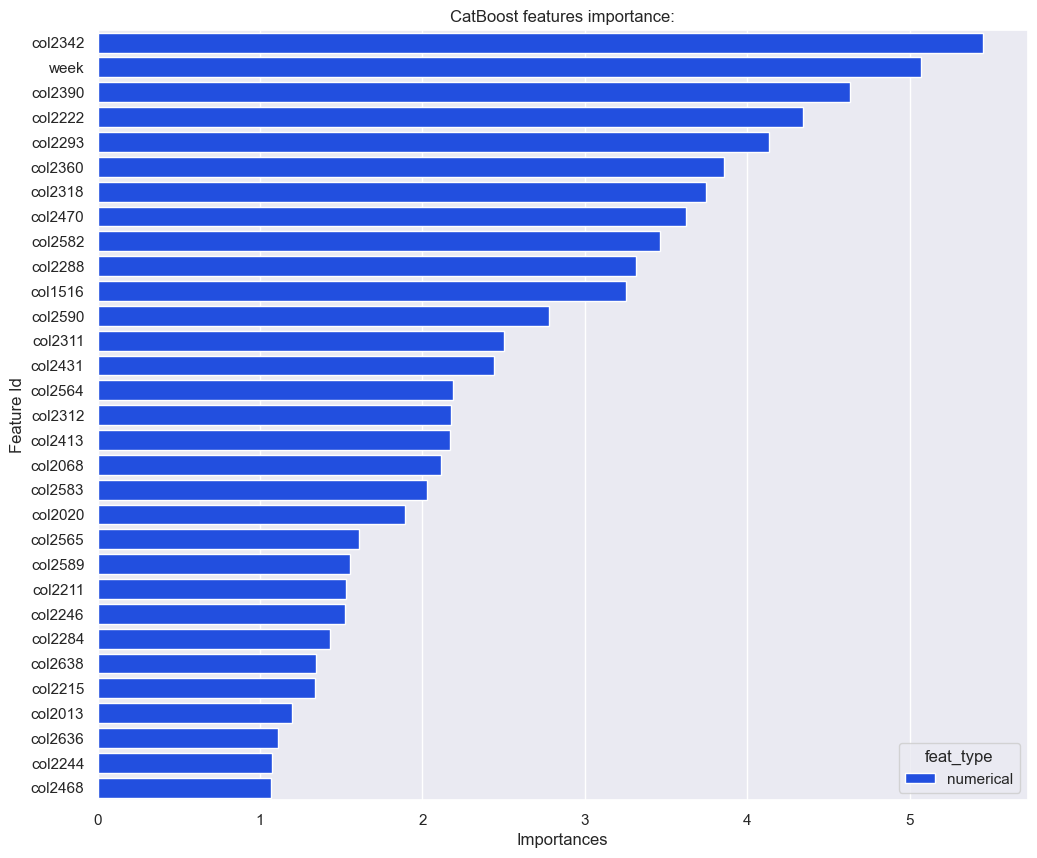

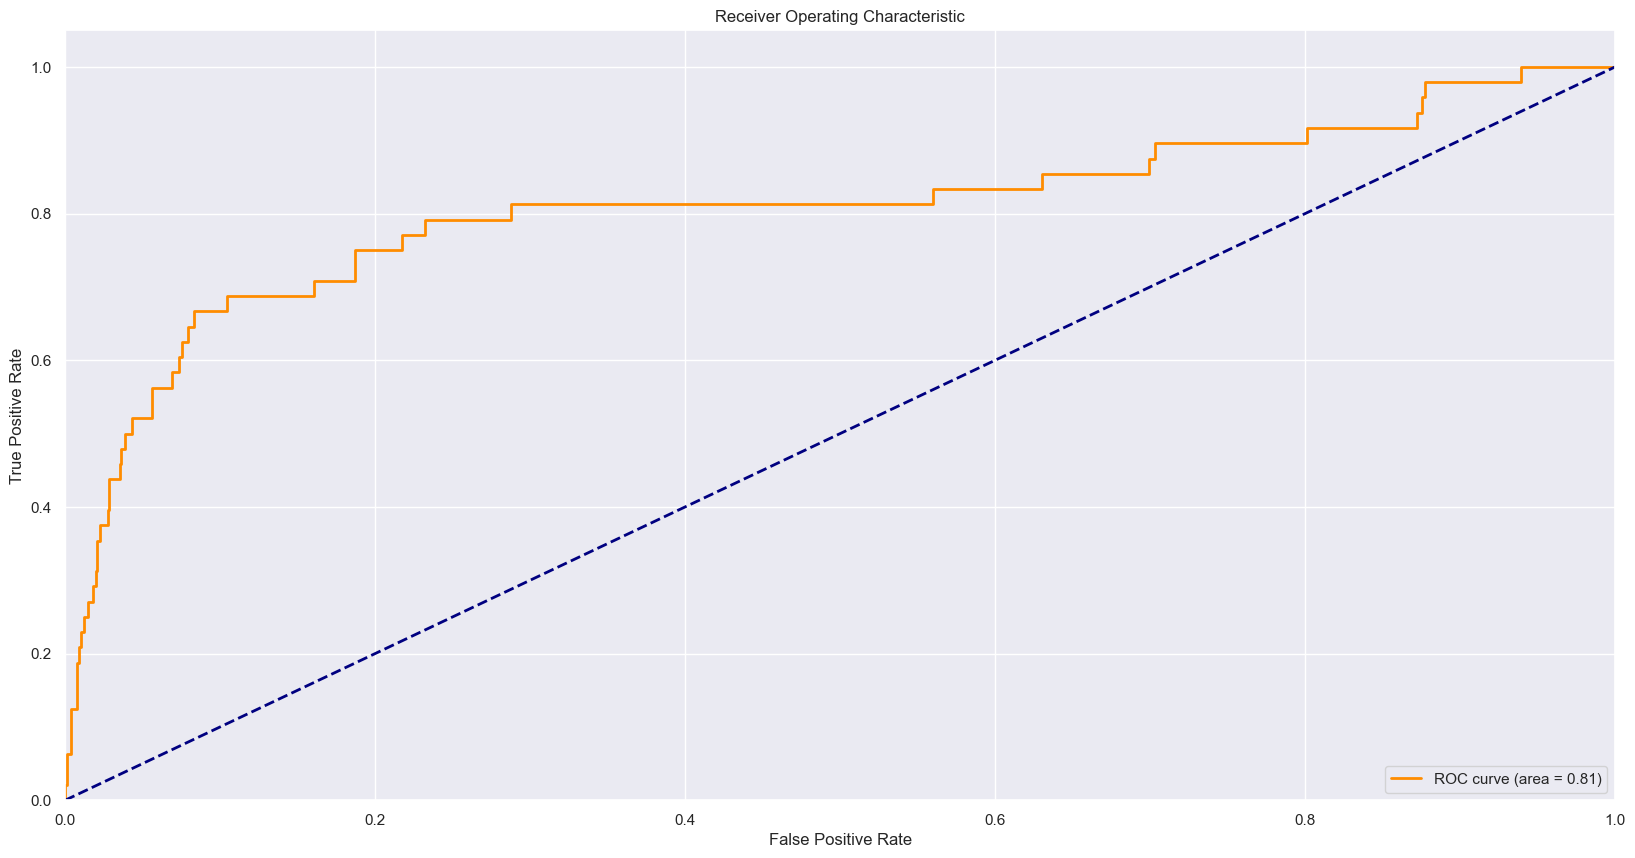

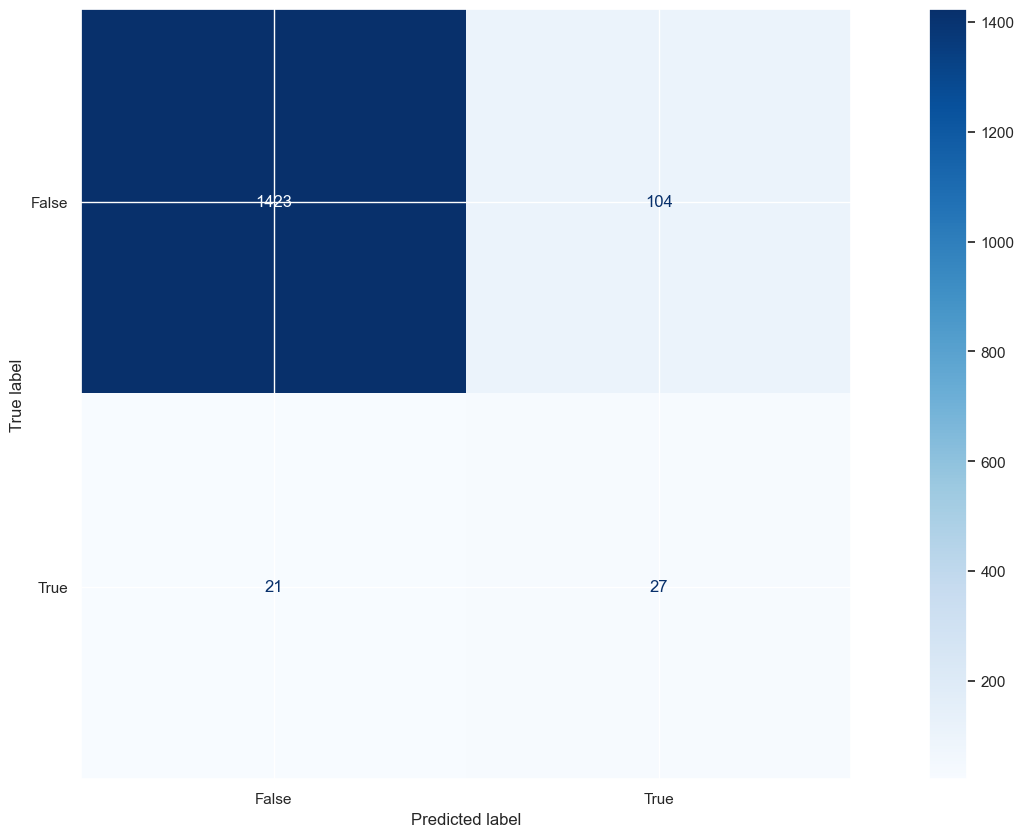

In [33]:
plot_model_info(
    model_cleansed,
    X_test_cleaned,
    y_test,
    catboost=True,
)

# Step 5. Hyperparameters Tuning

In [34]:
search_new_params = False
if search_new_params:
    hyperparams = search_best_params(X_train_cleaned, X_valid_cleaned, y_train, y_valid, max_evals=300)
else:
    with open('best_hyperparams_full_dataset.pkl', 'rb') as fp:
        hyperparams = pickle.load(fp)

In [35]:
# with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
#     pickle.dump(hyperparams, fp)

In [36]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
    'auto_class_weights': "Balanced",
}

In [37]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best = CatBoostClassifier(**params)
model_best.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

0:	learn: 0.6359802	test: 0.6493680	best: 0.6493680 (0)	total: 6.17ms	remaining: 876ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4732603469
bestIteration = 56

Shrink model to first 57 iterations.


In [38]:
# model_best.save_model('../models/best_model')

Classification report of the model
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1527
           1       0.19      0.67      0.30        48

    accuracy                           0.91      1575
   macro avg       0.59      0.79      0.62      1575
weighted avg       0.96      0.91      0.93      1575

ROC-AUC score is:  0.7897838899803535


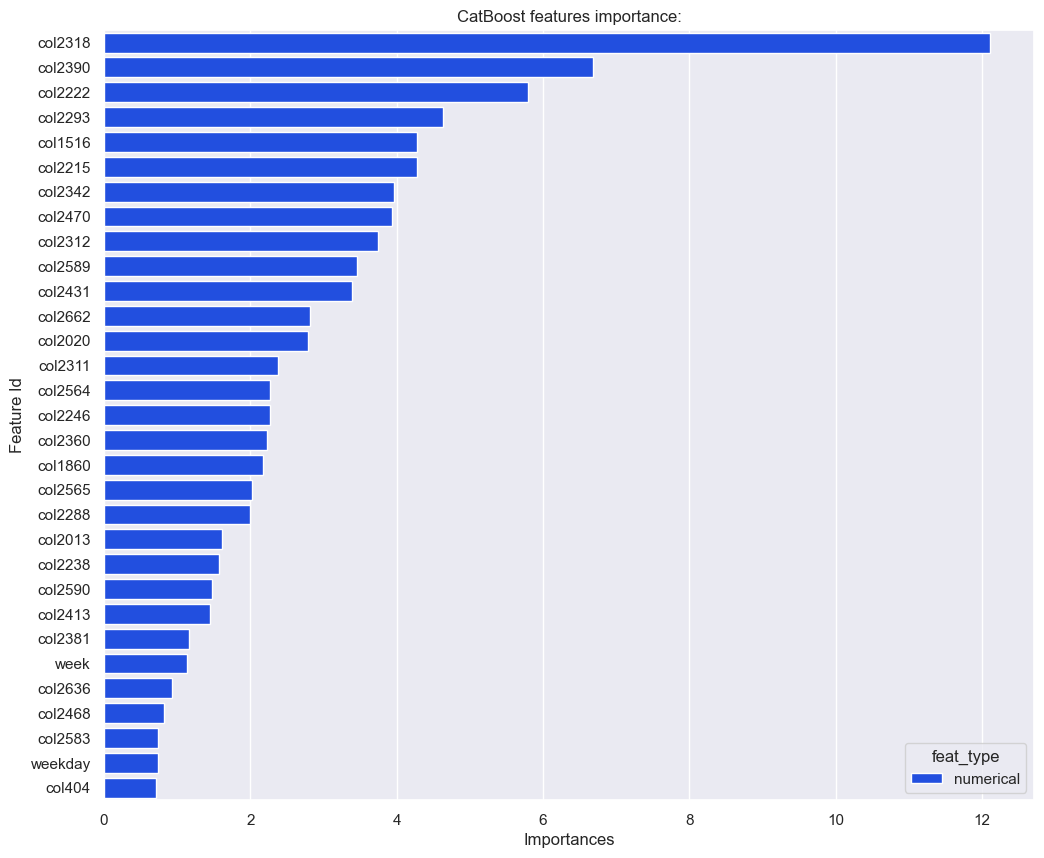

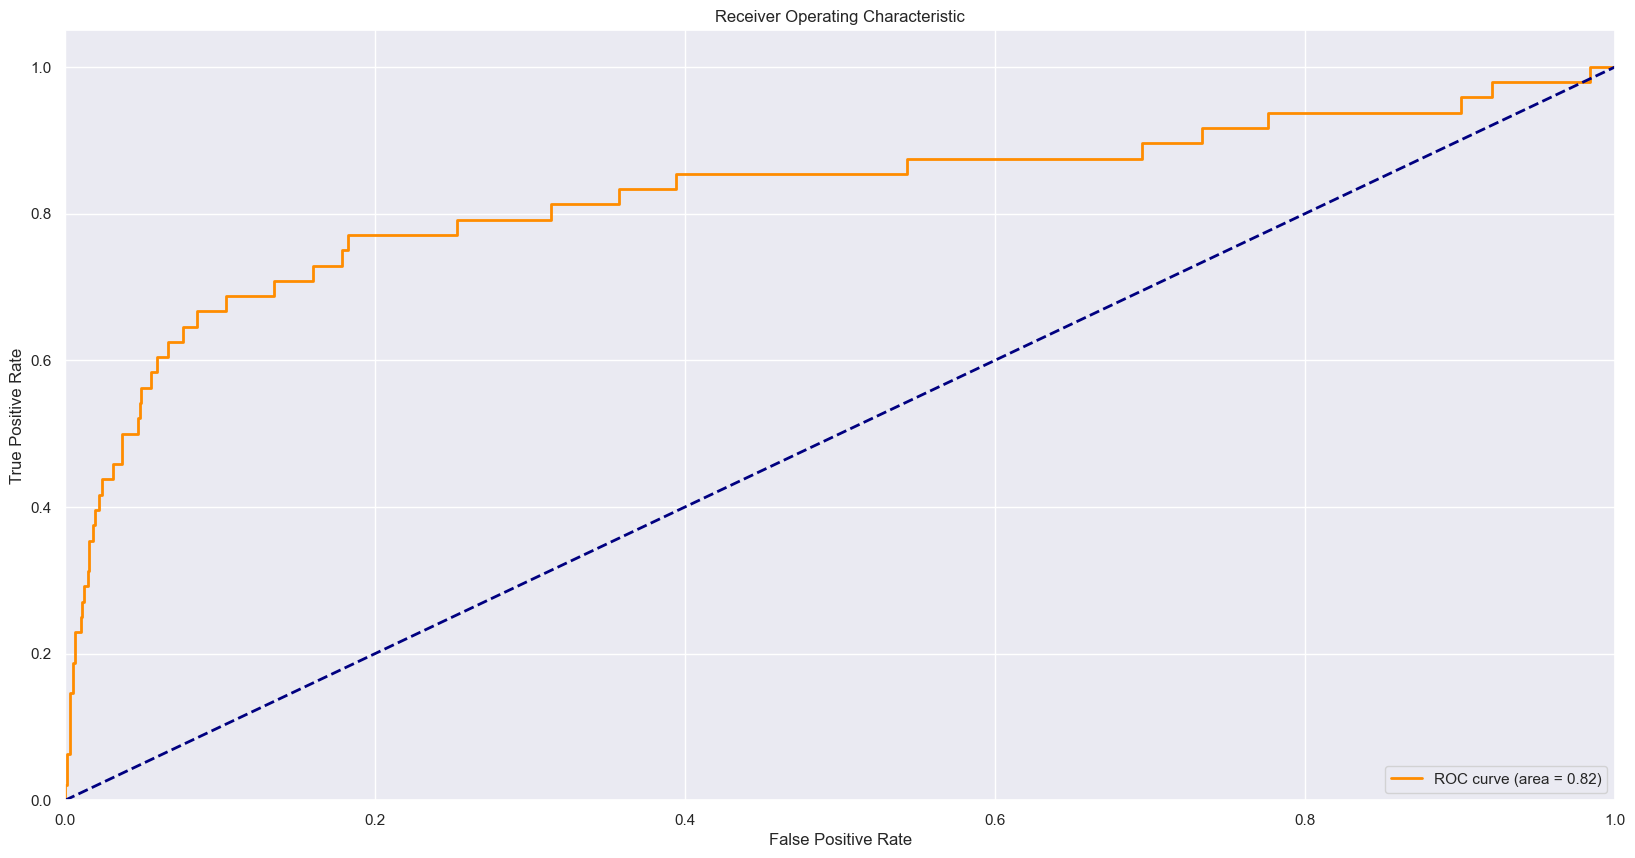

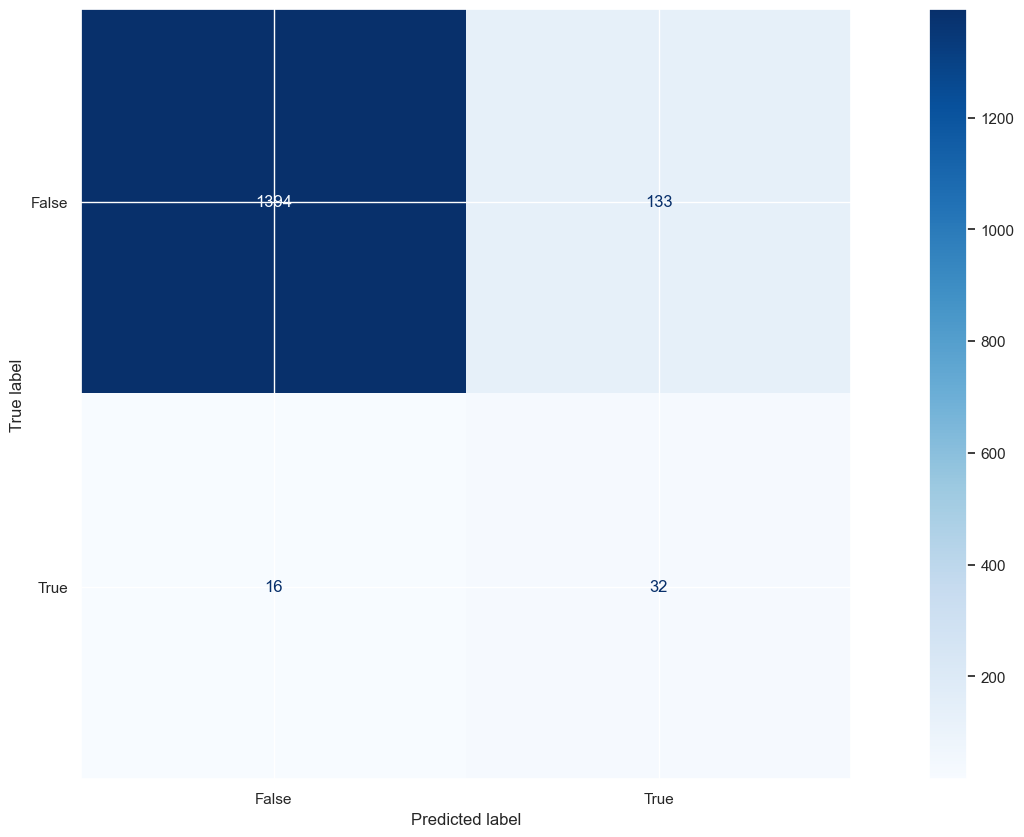

In [39]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
    catboost=True,
)

In [40]:
X_cleaned_cv = pd.concat([X_train_cleaned, X_valid_cleaned], ignore_index=True)
y_cv = pd.concat([y_train, y_valid], ignore_index=True)

# Step 6. Add Logistic Regression

In [41]:
# X_cleaned_cv, y_csv
preprocessor = get_transformer_data_for_regression(X_cleaned_cv) #X_train_cleaned

In [42]:
X_cv_linear = preprocessor.transform(X_cleaned_cv) # X_train_cleaned
X_test_linear = preprocessor.transform(X_test_cleaned)

PCA(n_components=100, svd_solver='full')

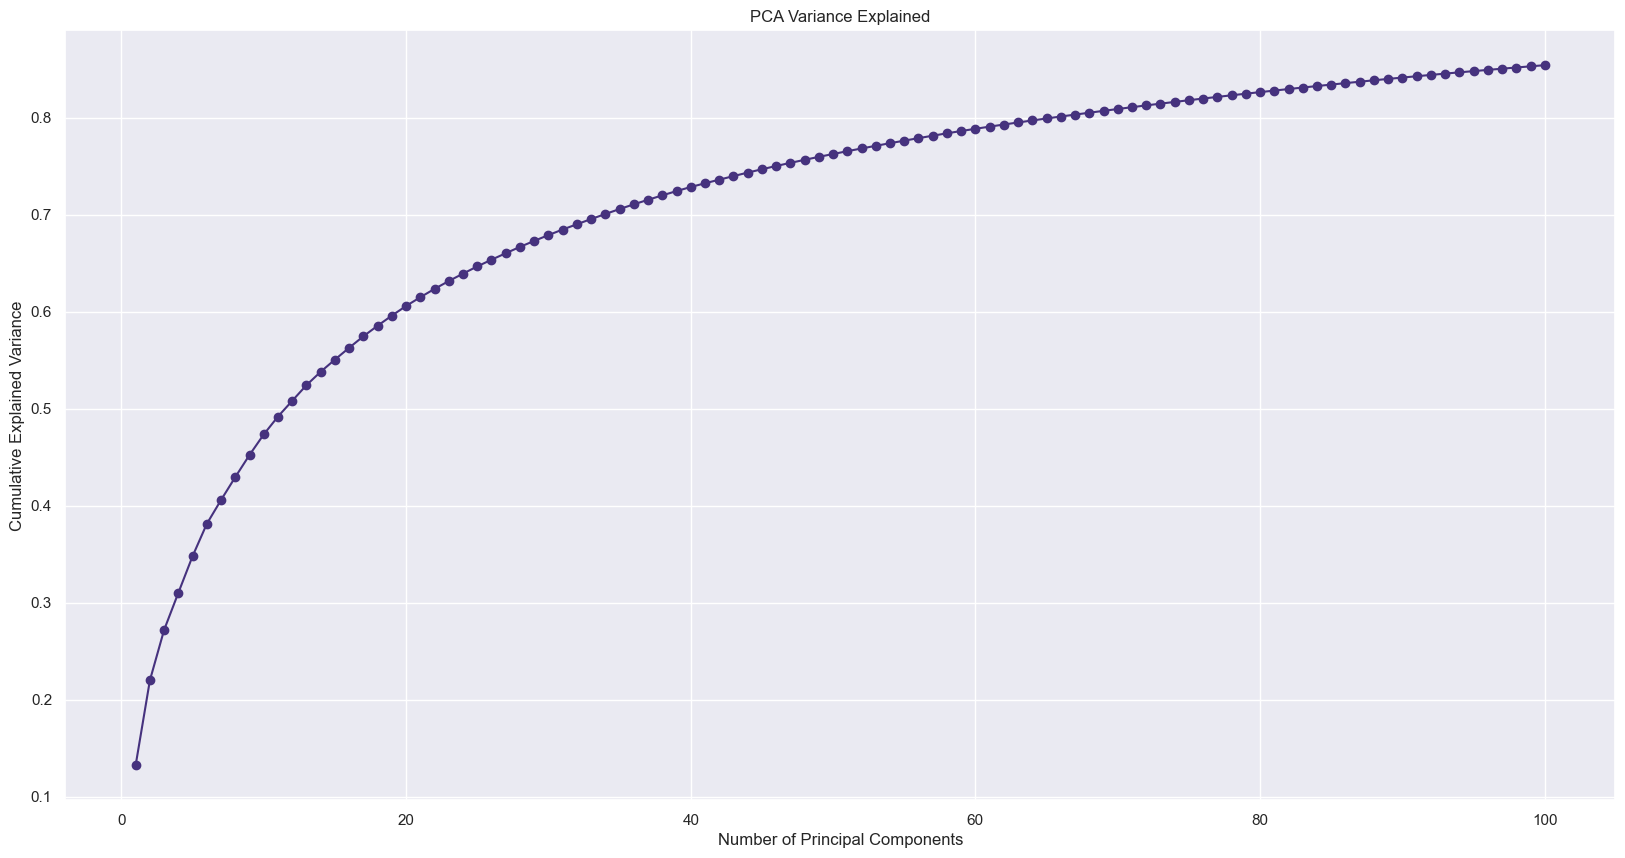

In [43]:
pca = PCA(n_components=min(100, len(X_cleaned_cv.columns)), svd_solver='full')
pca.fit(X_cv_linear)
plot_pca_variance(pca)

In [44]:
top_n = 60
X_cv_pca = pca.fit_transform(X_cv_linear)[:, :top_n]  # we select only top N features
X_test_pca = pca.transform(X_test_linear)[:, :`top_n]

### LogisticRegression

In [45]:
logreg = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=10)
logreg.fit(X_cv_pca, y_cv)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', n_jobs=10, random_state=42)

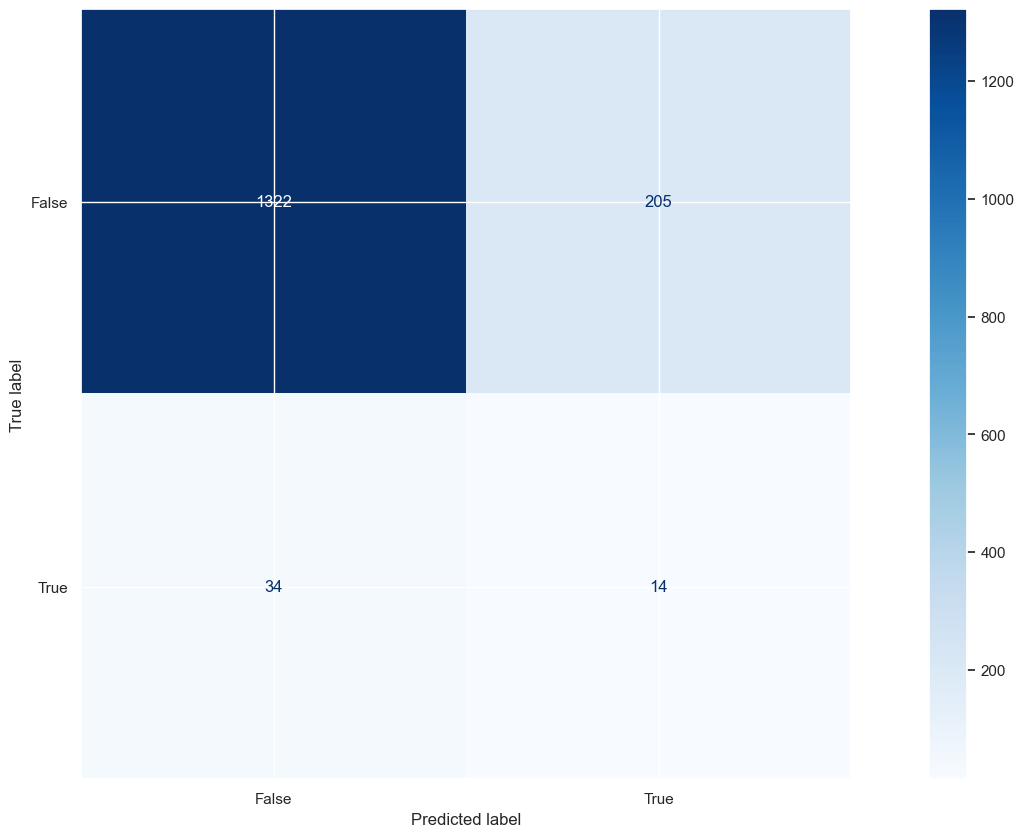

In [46]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(X_test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

### LogisticRegressionCV

In [47]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=42, class_weight='balanced', penalty='l2', n_jobs=10)
logreg_cv.fit(X_cv_pca, y_cv)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

LogisticRegressionCV(class_weight='balanced', cv=5, n_jobs=10, random_state=42)

ROC-AUC score is:  0.5852570399476098


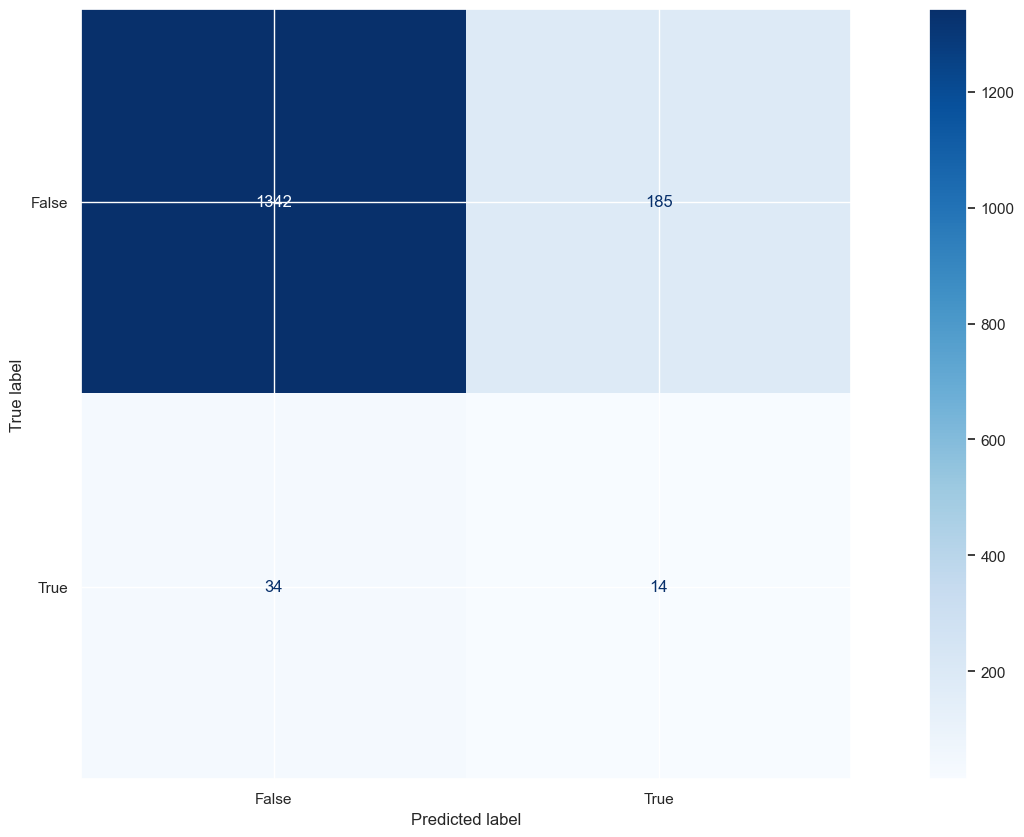

In [48]:
print("ROC-AUC score is: ", roc_auc_score(y_test, logreg_cv.predict(X_test_pca)))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_cv.predict(X_test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 7. CV

In [49]:
do_search_best_params_cv = True
if do_search_best_params_cv:
    model_best_cv, best_params = search_best_params_cv(X_cleaned_cv, y_cv, max_evals=50, early_stop_steps=100)
    # model_best_cv.save_model('../models/model_best_cv_3_just_in_case')
    # with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
    #     pickle.dump(hyperparams, fp)
else:
    model_best_cv = CatBoostClassifier()      # parameters not required.
    model_best_cv.load_model('../models/model_best_cv_3_just_in_case')

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2023-09-10 08:48:28,070 INFO build_posterior_wrapper took 0.000379 seconds
2023-09-10 08:48:28,070 INFO TPE using 0 trials


  2%|▏         | 1/50 [00:11<09:30, 11.65s/trial, best loss: 0.4881581450523803]

2023-09-10 08:48:39,721 INFO build_posterior_wrapper took 0.000304 seconds
2023-09-10 08:48:39,722 INFO TPE using 1/1 trials with best loss 0.488158


  4%|▍         | 2/50 [00:20<07:53,  9.87s/trial, best loss: 0.4881581450523803]

2023-09-10 08:48:48,336 INFO build_posterior_wrapper took 0.000297 seconds
2023-09-10 08:48:48,336 INFO TPE using 2/2 trials with best loss 0.488158


  6%|▌         | 3/50 [00:25<06:13,  7.95s/trial, best loss: 0.4881581450523803]

2023-09-10 08:48:53,998 INFO build_posterior_wrapper took 0.000317 seconds
2023-09-10 08:48:53,998 INFO TPE using 3/3 trials with best loss 0.488158


  8%|▊         | 4/50 [00:35<06:32,  8.54s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:03,438 INFO build_posterior_wrapper took 0.000285 seconds
2023-09-10 08:49:03,438 INFO TPE using 4/4 trials with best loss 0.488158


 10%|█         | 5/50 [00:39<05:18,  7.07s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:07,913 INFO build_posterior_wrapper took 0.000292 seconds
2023-09-10 08:49:07,913 INFO TPE using 5/5 trials with best loss 0.488158


 12%|█▏        | 6/50 [00:43<04:24,  6.01s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:11,849 INFO build_posterior_wrapper took 0.000324 seconds
2023-09-10 08:49:11,849 INFO TPE using 6/6 trials with best loss 0.488158


 14%|█▍        | 7/50 [00:48<03:53,  5.44s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:16,128 INFO build_posterior_wrapper took 0.000300 seconds
2023-09-10 08:49:16,128 INFO TPE using 7/7 trials with best loss 0.488158


 16%|█▌        | 8/50 [00:53<03:46,  5.40s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:21,446 INFO build_posterior_wrapper took 0.000298 seconds
2023-09-10 08:49:21,446 INFO TPE using 8/8 trials with best loss 0.488158


 18%|█▊        | 9/50 [01:03<04:44,  6.95s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:31,790 INFO build_posterior_wrapper took 0.000326 seconds
2023-09-10 08:49:31,790 INFO TPE using 9/9 trials with best loss 0.488158


 20%|██        | 10/50 [01:15<05:35,  8.38s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:43,386 INFO build_posterior_wrapper took 0.000307 seconds
2023-09-10 08:49:43,386 INFO TPE using 10/10 trials with best loss 0.488158


 22%|██▏       | 11/50 [01:23<05:29,  8.45s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:51,989 INFO build_posterior_wrapper took 0.000287 seconds
2023-09-10 08:49:51,989 INFO TPE using 11/11 trials with best loss 0.488158


 24%|██▍       | 12/50 [01:29<04:47,  7.55s/trial, best loss: 0.4881581450523803]

2023-09-10 08:49:57,497 INFO build_posterior_wrapper took 0.000305 seconds
2023-09-10 08:49:57,497 INFO TPE using 12/12 trials with best loss 0.488158


 26%|██▌       | 13/50 [01:35<04:22,  7.11s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:03,574 INFO build_posterior_wrapper took 0.000287 seconds
2023-09-10 08:50:03,575 INFO TPE using 13/13 trials with best loss 0.488158


 28%|██▊       | 14/50 [01:39<03:45,  6.27s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:07,894 INFO build_posterior_wrapper took 0.000344 seconds
2023-09-10 08:50:07,894 INFO TPE using 14/14 trials with best loss 0.488158


 30%|███       | 15/50 [01:55<05:22,  9.20s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:23,905 INFO build_posterior_wrapper took 0.000290 seconds
2023-09-10 08:50:23,905 INFO TPE using 15/15 trials with best loss 0.488158


 32%|███▏      | 16/50 [02:02<04:49,  8.50s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:30,775 INFO build_posterior_wrapper took 0.000289 seconds
2023-09-10 08:50:30,776 INFO TPE using 16/16 trials with best loss 0.488158


 34%|███▍      | 17/50 [02:08<04:13,  7.68s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:36,559 INFO build_posterior_wrapper took 0.000284 seconds
2023-09-10 08:50:36,559 INFO TPE using 17/17 trials with best loss 0.488158


 36%|███▌      | 18/50 [02:15<04:02,  7.57s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:43,859 INFO build_posterior_wrapper took 0.000333 seconds
2023-09-10 08:50:43,860 INFO TPE using 18/18 trials with best loss 0.488158


 38%|███▊      | 19/50 [02:22<03:44,  7.24s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:50,340 INFO build_posterior_wrapper took 0.000291 seconds
2023-09-10 08:50:50,341 INFO TPE using 19/19 trials with best loss 0.488158


 40%|████      | 20/50 [02:31<03:58,  7.95s/trial, best loss: 0.4881581450523803]

2023-09-10 08:50:59,934 INFO build_posterior_wrapper took 0.000305 seconds
2023-09-10 08:50:59,935 INFO TPE using 20/20 trials with best loss 0.488158


 42%|████▏     | 21/50 [02:58<06:34, 13.59s/trial, best loss: 0.4861887478708961]

2023-09-10 08:51:26,670 INFO build_posterior_wrapper took 0.000305 seconds
2023-09-10 08:51:26,670 INFO TPE using 21/21 trials with best loss 0.486189


 44%|████▍     | 22/50 [03:04<05:13, 11.18s/trial, best loss: 0.4861887478708961]

2023-09-10 08:51:32,234 INFO build_posterior_wrapper took 0.000308 seconds
2023-09-10 08:51:32,235 INFO TPE using 22/22 trials with best loss 0.486189


 46%|████▌     | 23/50 [03:24<06:13, 13.83s/trial, best loss: 0.4861887478708961]

2023-09-10 08:51:52,257 INFO build_posterior_wrapper took 0.000316 seconds
2023-09-10 08:51:52,257 INFO TPE using 23/23 trials with best loss 0.486189


 48%|████▊     | 24/50 [03:32<05:18, 12.24s/trial, best loss: 0.4861887478708961]

2023-09-10 08:52:00,780 INFO build_posterior_wrapper took 0.000290 seconds
2023-09-10 08:52:00,780 INFO TPE using 24/24 trials with best loss 0.486189


 50%|█████     | 25/50 [03:39<04:28, 10.74s/trial, best loss: 0.4861887478708961]

2023-09-10 08:52:08,015 INFO build_posterior_wrapper took 0.000300 seconds
2023-09-10 08:52:08,015 INFO TPE using 25/25 trials with best loss 0.486189


 52%|█████▏    | 26/50 [03:59<05:23, 13.50s/trial, best loss: 0.4861887478708961]

2023-09-10 08:52:27,942 INFO build_posterior_wrapper took 0.000300 seconds
2023-09-10 08:52:27,942 INFO TPE using 26/26 trials with best loss 0.486189


 54%|█████▍    | 27/50 [04:16<05:31, 14.39s/trial, best loss: 0.48371417134092665]

2023-09-10 08:52:44,426 INFO build_posterior_wrapper took 0.000344 seconds
2023-09-10 08:52:44,426 INFO TPE using 27/27 trials with best loss 0.483714


 56%|█████▌    | 28/50 [04:38<06:08, 16.76s/trial, best loss: 0.48371417134092665]

2023-09-10 08:53:06,702 INFO build_posterior_wrapper took 0.000353 seconds
2023-09-10 08:53:06,703 INFO TPE using 28/28 trials with best loss 0.483714


 58%|█████▊    | 29/50 [04:58<06:11, 17.69s/trial, best loss: 0.48371417134092665]

2023-09-10 08:53:26,585 INFO build_posterior_wrapper took 0.000299 seconds
2023-09-10 08:53:26,585 INFO TPE using 29/29 trials with best loss 0.483714


 60%|██████    | 30/50 [06:03<10:39, 32.00s/trial, best loss: 0.48371417134092665]

2023-09-10 08:54:31,959 INFO build_posterior_wrapper took 0.000319 seconds
2023-09-10 08:54:31,959 INFO TPE using 30/30 trials with best loss 0.483714


 62%|██████▏   | 31/50 [06:22<08:51, 27.97s/trial, best loss: 0.48371417134092665]

2023-09-10 08:54:50,545 INFO build_posterior_wrapper took 0.000331 seconds
2023-09-10 08:54:50,545 INFO TPE using 31/31 trials with best loss 0.483714


 64%|██████▍   | 32/50 [06:42<07:41, 25.61s/trial, best loss: 0.48371417134092665]

2023-09-10 08:55:10,646 INFO build_posterior_wrapper took 0.000320 seconds
2023-09-10 08:55:10,646 INFO TPE using 32/32 trials with best loss 0.483714


 66%|██████▌   | 33/50 [07:44<10:19, 36.44s/trial, best loss: 0.48371417134092665]

2023-09-10 08:56:12,356 INFO build_posterior_wrapper took 0.000305 seconds
2023-09-10 08:56:12,356 INFO TPE using 33/33 trials with best loss 0.483714


 68%|██████▊   | 34/50 [08:04<08:25, 31.57s/trial, best loss: 0.48371417134092665]

2023-09-10 08:56:32,543 INFO build_posterior_wrapper took 0.000331 seconds
2023-09-10 08:56:32,543 INFO TPE using 34/34 trials with best loss 0.483714


 70%|███████   | 35/50 [08:15<06:20, 25.37s/trial, best loss: 0.48371417134092665]

2023-09-10 08:56:43,462 INFO build_posterior_wrapper took 0.000299 seconds
2023-09-10 08:56:43,462 INFO TPE using 35/35 trials with best loss 0.483714


 72%|███████▏  | 36/50 [08:24<04:46, 20.45s/trial, best loss: 0.48371417134092665]

2023-09-10 08:56:52,439 INFO build_posterior_wrapper took 0.000301 seconds
2023-09-10 08:56:52,440 INFO TPE using 36/36 trials with best loss 0.483714


 74%|███████▍  | 37/50 [08:34<03:47, 17.49s/trial, best loss: 0.48371417134092665]

2023-09-10 08:57:03,015 INFO build_posterior_wrapper took 0.000307 seconds
2023-09-10 08:57:03,015 INFO TPE using 37/37 trials with best loss 0.483714


 76%|███████▌  | 38/50 [08:44<03:01, 15.10s/trial, best loss: 0.48371417134092665]

2023-09-10 08:57:12,536 INFO build_posterior_wrapper took 0.000340 seconds
2023-09-10 08:57:12,536 INFO TPE using 38/38 trials with best loss 0.483714


 78%|███████▊  | 39/50 [08:51<02:18, 12.57s/trial, best loss: 0.48371417134092665]

2023-09-10 08:57:19,210 INFO build_posterior_wrapper took 0.000297 seconds
2023-09-10 08:57:19,211 INFO TPE using 39/39 trials with best loss 0.483714


 80%|████████  | 40/50 [09:00<01:55, 11.53s/trial, best loss: 0.48371417134092665]

2023-09-10 08:57:28,303 INFO build_posterior_wrapper took 0.000291 seconds
2023-09-10 08:57:28,304 INFO TPE using 40/40 trials with best loss 0.483714


 82%|████████▏ | 41/50 [09:08<01:34, 10.53s/trial, best loss: 0.48371417134092665]

2023-09-10 08:57:36,488 INFO build_posterior_wrapper took 0.000308 seconds
2023-09-10 08:57:36,488 INFO TPE using 41/41 trials with best loss 0.483714


 84%|████████▍ | 42/50 [09:24<01:37, 12.14s/trial, best loss: 0.48371417134092665]

2023-09-10 08:57:52,411 INFO build_posterior_wrapper took 0.000303 seconds
2023-09-10 08:57:52,411 INFO TPE using 42/42 trials with best loss 0.483714


 86%|████████▌ | 43/50 [09:34<01:20, 11.53s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:02,520 INFO build_posterior_wrapper took 0.000307 seconds
2023-09-10 08:58:02,520 INFO TPE using 43/43 trials with best loss 0.483714


 88%|████████▊ | 44/50 [09:39<00:56,  9.48s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:07,210 INFO build_posterior_wrapper took 0.000302 seconds
2023-09-10 08:58:07,210 INFO TPE using 44/44 trials with best loss 0.483714


 90%|█████████ | 45/50 [09:42<00:37,  7.55s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:10,269 INFO build_posterior_wrapper took 0.000292 seconds
2023-09-10 08:58:10,269 INFO TPE using 45/45 trials with best loss 0.483714


 92%|█████████▏| 46/50 [09:48<00:29,  7.27s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:16,890 INFO build_posterior_wrapper took 0.000296 seconds
2023-09-10 08:58:16,891 INFO TPE using 46/46 trials with best loss 0.483714


 94%|█████████▍| 47/50 [09:55<00:21,  7.05s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:23,427 INFO build_posterior_wrapper took 0.000297 seconds
2023-09-10 08:58:23,427 INFO TPE using 47/47 trials with best loss 0.483714


 96%|█████████▌| 48/50 [10:03<00:14,  7.28s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:31,233 INFO build_posterior_wrapper took 0.000302 seconds
2023-09-10 08:58:31,234 INFO TPE using 48/48 trials with best loss 0.483714


 98%|█████████▊| 49/50 [10:08<00:06,  6.65s/trial, best loss: 0.48371417134092665]

2023-09-10 08:58:36,427 INFO build_posterior_wrapper took 0.000302 seconds
2023-09-10 08:58:36,427 INFO TPE using 49/49 trials with best loss 0.483714


100%|██████████| 50/50 [10:11<00:00, 12.23s/trial, best loss: 0.48371417134092665]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
# X_cleaned_cv = pd.concat([X_train_cleaned, X_valid_cleaned], ignore_index=True)
# y_cv = pd.concat([y_train, y_valid], ignore_index=True)
# categorical_columns = X_cleaned_cv.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
# model_best_cv = CatBoostClassifier(**best_params)
# model_best_cv.fit(
#     X=X_cleaned_cv,
#     y=y_cv,
#     # eval_set=(X_valid_cleaned, y_valid),
#     verbose=250,
#     cat_features=categorical_columns
# )

In [51]:
# model_best_cv.save_model('../models/model_best_cv_3_just_in_case')

Classification report of the model
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1527
           1       0.19      0.67      0.30        48

    accuracy                           0.91      1575
   macro avg       0.59      0.79      0.62      1575
weighted avg       0.96      0.91      0.93      1575

ROC-AUC score is:  0.7897838899803535


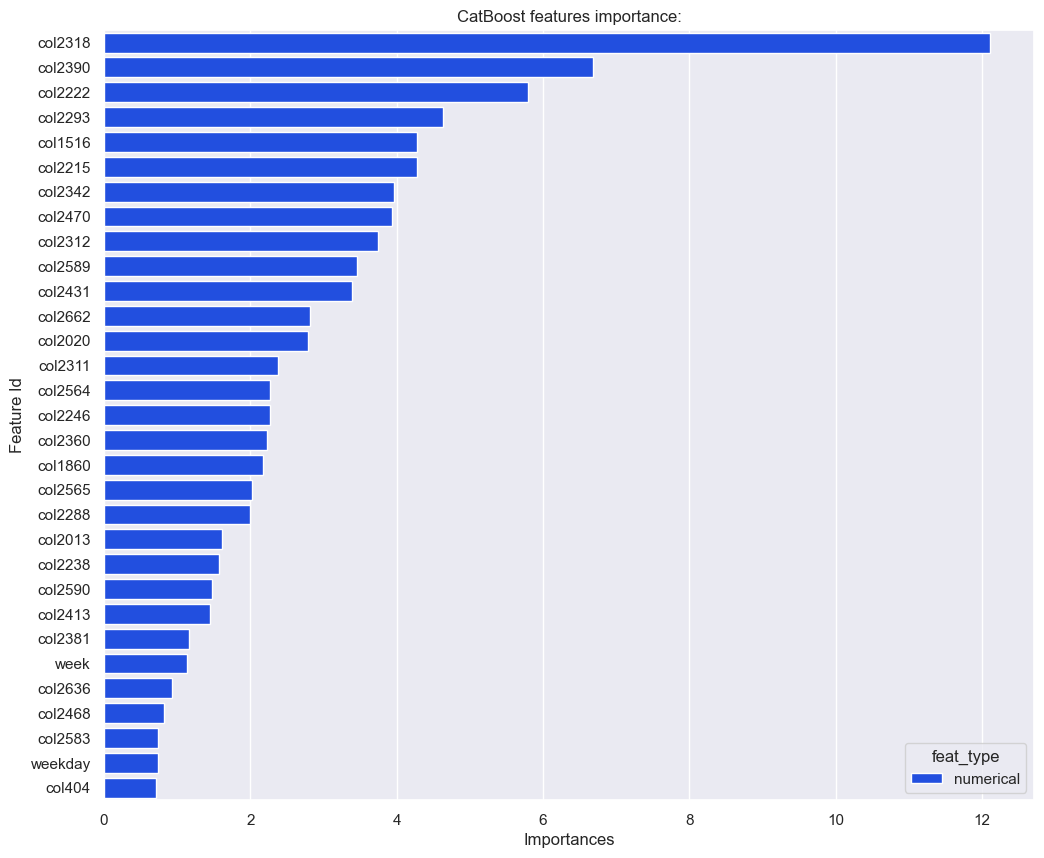

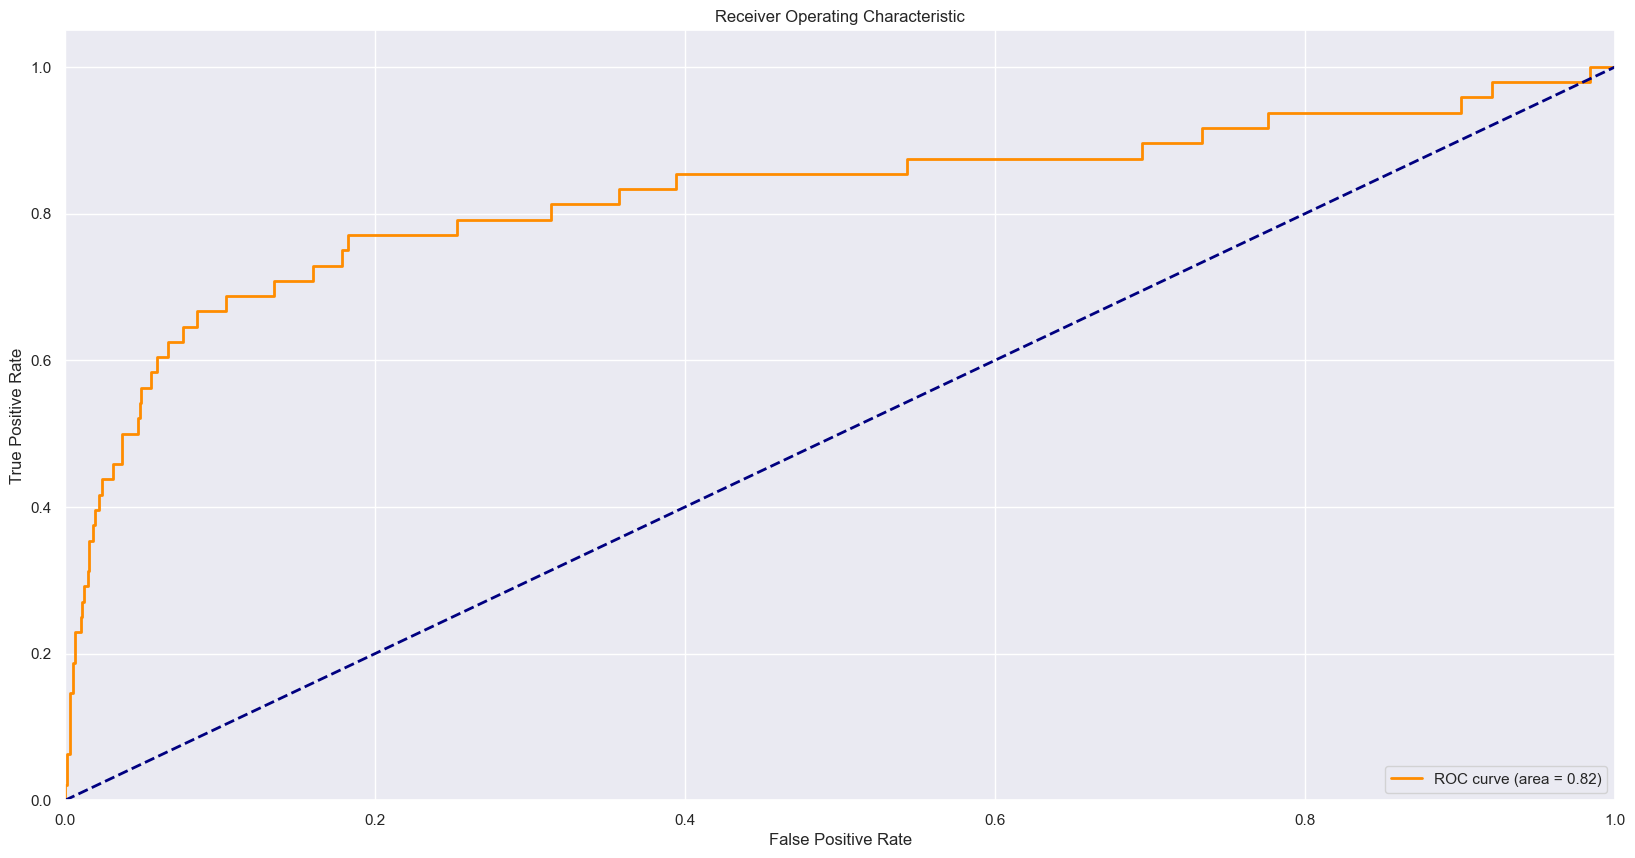

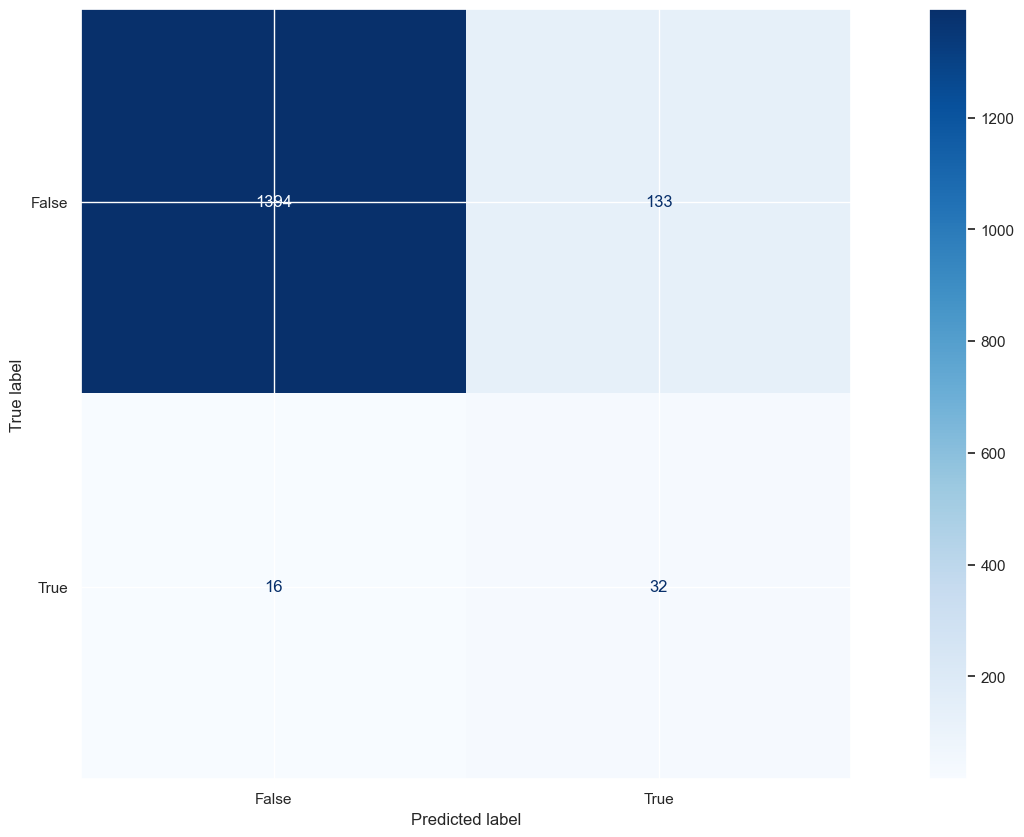

In [52]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
    catboost=True,
)

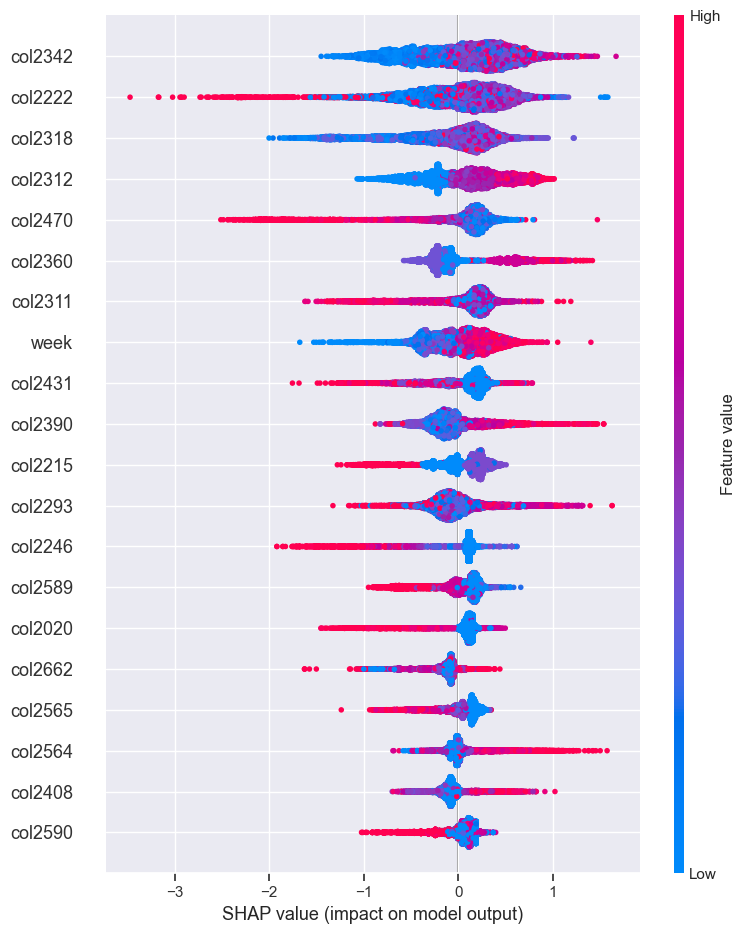

In [53]:
categorical_columns = X_cleaned_cv.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
train_data = Pool(data=X_cleaned_cv, label=y_cv, cat_features=categorical_columns)

explainer = shap.TreeExplainer(model_best_cv)
shap_values = explainer.shap_values(train_data)

shap.summary_plot(shap_values, X_cleaned_cv)

# Step 8. Logistic Regression + CatBoost

In [54]:
# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_test_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(X_test_pca)[:, 1]

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.8, 0.2], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]

ROC-AUC score is:  0.7800221021611004


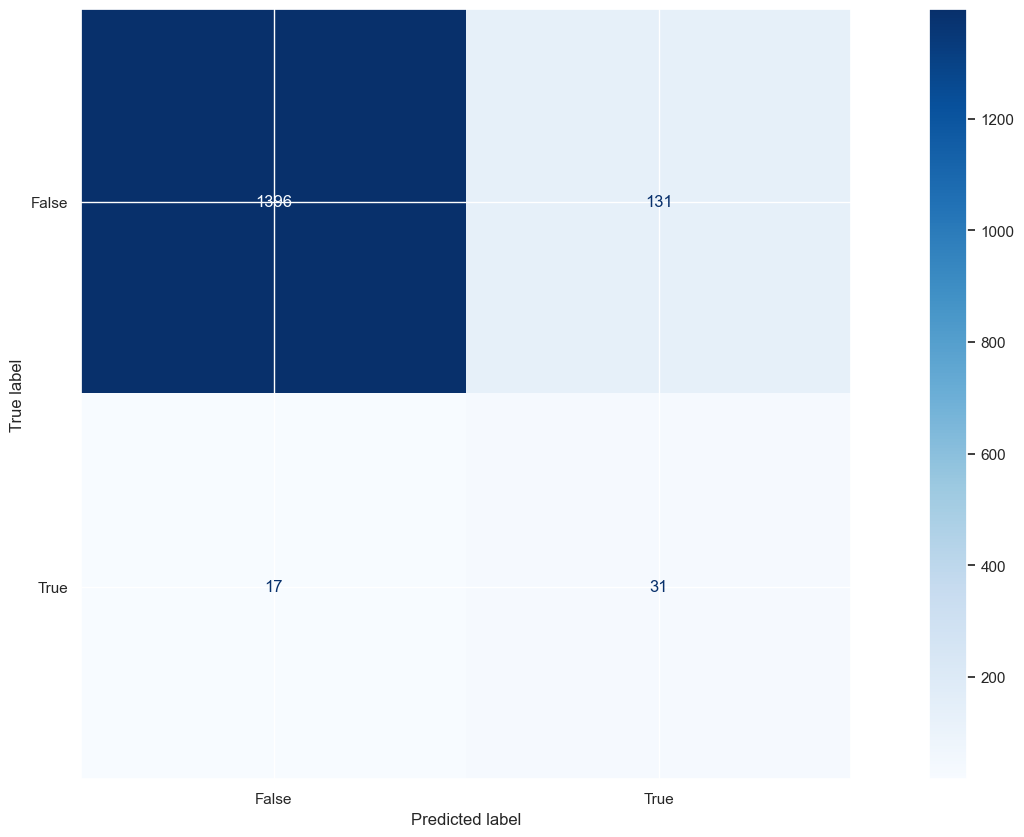

In [55]:
print("ROC-AUC score is: ", roc_auc_score(y_test, final_class_preds))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, final_class_preds), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

In [56]:
print('Classification report of the model\n', classification_report(y_test, final_class_preds))

Classification report of the model
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1527
           1       0.19      0.65      0.30        48

    accuracy                           0.91      1575
   macro avg       0.59      0.78      0.62      1575
weighted avg       0.96      0.91      0.93      1575


# Step 9. Prediction

In [57]:
# model = CatBoostClassifier()      # parameters not required.
# model.load_model('../models/model_best_cv_2')

In [65]:
not_null_columns_names.remove("target")

In [66]:
X_lead_orig = pd.read_csv("../data/raw/test.csv", sep=";")
# X_lead = pd.read_csv('')
X_lead = create_date_features(X_lead_orig)
X_lead = X_lead[not_null_columns_names]
X_lead = X_lead.drop(columns=["client_id", "report_date", "col1454"])

categorical_columns = (
    X_lead
    .select_dtypes(exclude=["float64", "int64"])
    .columns
)
numerical_columns = (
    X_lead
    .select_dtypes(include=["float64", "int64"])
    .columns
)
X_lead[numerical_columns] = X_lead[numerical_columns].fillna(0)
X_lead[categorical_columns] = X_lead[categorical_columns].astype(str)
logger.info("DONE - Initial Preprocessing")


X_lead_cleaned = X_lead.iloc[:, useful_column_indices]
X_lead_linear = preprocessor.transform(X_lead_cleaned)
X_lead_pca = pca.transform(X_lead_linear)[:, :top_n]
logger.info("DONE - Data transformation for pca")

# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_lead_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(X_lead_pca)[:, 1]
logger.info("DONE - Model predictions")

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.6, 0.4], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]
X_lead_orig["target"] = final_class_preds

2023-09-10 09:06:36,947 INFO DONE - Initial Preprocessing
2023-09-10 09:06:37,169 INFO DONE - Data transformation for pca
2023-09-10 09:06:37,189 INFO DONE - Model predictions


In [71]:
X_lead_orig["target"] = final_class_preds

In [74]:
X_lead_orig[["id", "target"]].to_csv("my_submission.csv", sep=";", index=False)

In [ ]:
# uncomment for leaderboard prediction
# X_lead_orig['target'] = final_class_preds